In [19]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time
from scipy import stats
import random

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [20]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

def LOSOCV_Tasks(Data,X,y,groups,tasks):

    DataOrig = Data.copy()
    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each task subset

    m = [RandomForestClassifier(n_estimators=50,random_state=2),'Random Forest']
    clf=m[0]; model_name=m[1]
    for T in tasks:
        print(Data.shape)
#         Data = DataOrig.copy()
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
          
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            task_inds = Data.Task.iloc[test_index]==T[0]
            for Ti in T[1::]:
                task_inds = task_inds | (Data.Task.iloc[test_index]==Ti)
#             print(test_index, sum(task_inds))
            test_index = test_index[task_inds.values]
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
#             print(len(test_index),sum(task_inds))
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve',T)
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            #the recall per task - TO BE COMPLETED

#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks

            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)

            #store feature importance
            fi_all.append(clf.feature_importances_)

            s+=1

        #group results for each model
        groupres[tuple(T)] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

In [21]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

### New Helper Functions

In [22]:
def LNSOCV(Data,X,y,groups,N=1,reps=10):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model

    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

    m = [RandomForestClassifier(n_estimators=50,random_state=2),'Random Forest']
    
    clf = m[0]; model_name = m[1]            
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for i in range(0,reps):
        while True:
            r = random_combination(np.unique(groups),N)
            train_index, test_index = (groups!=r[0]), (groups==r[0])
            for n in range(1,N):
                train_index = (train_index)&(groups!=r[n])
            train_index = np.array(train_index)
            test_index = np.array(test_index)
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if (len(np.unique(ytr))==2) & (len(np.unique(yte))==2):
                break
            else:
                print('imbalanced classes')
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        #accuracy on train set
        ypred_train = clf.predict(Xtr)
        acc_train.append(sum(ypred_train==ytr)/len(ytr))
        auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

        #f1-score, prec, recall, specificity, auprc, auroc
        f1_test_all.append(f1_score(yte,ypred))
        precision, recall, _ = precision_recall_curve(yte,yscore)
        auprc = auc(recall,precision)
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        spec = sum((ypred==0) & (yte==0))/sum(yte==0)


        prec_all.append(precision_score(yte,ypred))
        rec_all.append(recall_score(yte,ypred))
        auprc_all.append(auprc)
        auroc_all.append(auroc)
        auroc_train_all.append(auroc_train)
        spec_all.append(spec)

        #the recall per task - TO BE COMPLETED

#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks

        #compute ROC points at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]

        if len(np.unique(yte))>1:                
            nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
            neg_counts = sum(yte==0)
            for f in fpr:
                ind = neg_counts-int(neg_counts*f)-1
                t = (nscores[ind])[0]
                if f==1:
                    t = 0
                tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        fpr_all.append(fpr); tpr_all.append(tpr)

        #store feature importance
        if model_name != 'SVM':
            fi_all.append(clf.feature_importances_)

        print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                             spec,auroc_train,auroc))
        s+=1

    print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
    np.nanmean(f1_test_all),np.nanstd(f1_test_all),
    np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
    np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))

    #group results for each model
    groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                            'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

    #mean across groups for each model
    r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                    ,index=[0])
    results = pd.concat((results,r))
        
    return results,groupres 

def featureUnpack(Data, sensor_list):
    #unpack features
    colnames=['rangeX', 'rangeY', 'rangeZ', 'skewX', 'skewY', 'skewZ',
           'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
           'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
           'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
           'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

    feat_index = [3,4,5,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
    
    colnames1=[i+'acc' for i in colnames]
    colnames2=[i+'gyr' for i in colnames]
    colnames=colnames1+colnames2
    
    Datafinal = pd.DataFrame()

    for i in range(len(Data)):
        Datatemp=pd.DataFrame()
        for sensors in sensor_list:
            if (sensors[0:6]!="flexor")&(sensors[0:6]!="medial"):
                F1 = Data[sensors + '_accel'].iloc[i]
                F2 = Data[sensors + '_gyro'].iloc[i]
                F = pd.DataFrame(data=np.hstack((F1[feat_index],F2[feat_index])).reshape(-1,1).T,index=[i],columns=[i+'_'+sensors for i in colnames])
                Datatemp=pd.concat((Datatemp,F),axis=1)
            else:
                F1 = Data[sensors + '_accel'].iloc[i]
                F = pd.DataFrame(data=F1[feat_index].reshape(-1,1).T,index=[i],columns=[i+'_'+sensors for i in colnames1])
                Datatemp=pd.concat((Datatemp,F),axis=1)
        Datafinal = pd.concat((Datafinal,Datatemp),axis=0)
        
    Datafinal=Datafinal.reset_index(drop=True)
    Data=Data.reset_index(drop=True)
    Datafinal = pd.concat((Data.iloc[:,:7],Datafinal),axis=1)
      
    return Datafinal

def CombineSubjData(index):
    ### index: 0 for HP, 1 for HP+LP
    type_list = ['HP', 'HP+LP']
    features_path = 'DataFiles/Features_' + type_list[index] + '/'
    d = os.listdir(features_path)
    fnames  = [f for f in d if f[0]=='1']
    
    Data = pd.DataFrame()
    for f in fnames:
        Data_subj = pd.read_hdf(os.path.join(features_path,f))
        Data = pd.concat((Data,Data_subj))

    print(Data.shape)
    Data.drop('unknown_location_accel',axis=1,inplace=True)
    
    for s in Data.columns.values[7:]:
        print('%s,discarded %d rows'%(s,sum(Data[s].apply(type) == float)))
        Data = Data[Data[s].apply(type) != float]

    print(Data.shape)
    with open('DataFiles/Features_AllLocs' + type_list[index] + '.pkl','wb') as f:
        pickle.dump(Data,f)
        
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

In [5]:
feat_index = [3,4,5,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
index=1
type_list = ['HP', 'HP+LP']
features_path = 'DataFiles/Features_' + type_list[index] + '/'
d = os.listdir(features_path)
fnames  = [f for f in d if f[0]=='1']

Data = pd.DataFrame()
f = fnames[0]
Data_subj = pd.read_hdf(os.path.join(features_path,f))

In [6]:
Data_subj['dorsal_hand_ipsi_accel'].iloc[0]

array([  7.98993081e-03,   9.61279889e-03,   6.77657827e-03,
         5.99503538e-01,   7.44751519e-01,   4.83157929e-01,
        -2.40642681e-03,   7.53423107e-03,   3.76210347e-03,
         1.41335821e-01,   1.69900803e-01,   1.19830867e-01,
        -1.15820091e-01,  -3.19577039e-01,  -2.29859155e-01,
        -8.20024872e-01,  -4.03849938e-01,  -6.43427487e-01,
         3.13625034e+00,   3.06259632e+00,   3.52073047e+00,
         5.81469649e-01,   2.97124601e-01,   2.33226837e-01,
         2.44287432e+00,   1.44700154e-01,   9.23864483e-04,
         1.54843612e-03,   1.65070368e+00,   1.31349416e+00,
         6.22051925e-04,   2.27994851e-02,  -2.73488095e-01,
        -1.51047119e-01,   3.29215168e-01,   4.86044440e-01,
         3.93301622e-01])

In [7]:
Data_subj['dorsal_hand_ipsi_accel'].iloc[0][feat_index]

array([  5.99503538e-01,   7.44751519e-01,   4.83157929e-01,
        -1.15820091e-01,  -3.19577039e-01,  -2.29859155e-01,
        -8.20024872e-01,  -4.03849938e-01,  -6.43427487e-01,
         3.13625034e+00,   3.06259632e+00,   3.52073047e+00,
         5.81469649e-01,   2.97124601e-01,   2.33226837e-01,
         2.44287432e+00,   1.44700154e-01,   9.23864483e-04,
         1.54843612e-03,   1.65070368e+00,   1.31349416e+00,
         6.22051925e-04,   2.27994851e-02,  -2.73488095e-01,
        -1.51047119e-01,   3.29215168e-01,   4.86044440e-01,
         3.93301622e-01])

## Load and save data

In [8]:
if os.path.isfile('DataFiles/Features_AllLocsHP+LP.pkl'):
    with open('DataFiles/Features_AllLocsHP+LP.pkl', 'rb') as f:
        BradyData = pickle.load(f)
else:
    CombineSubjData(1)
    with open('DataFiles/Features_AllLocsHP+LP.pkl', 'rb') as f:
        BradyData = pickle.load(f)

In [9]:
if os.path.isfile('DataFiles/Features_AllLocsHP.pkl'):
    with open('DataFiles/Features_AllLocsHP.pkl', 'rb') as f:
        TremorData = pickle.load(f)
else:
    CombineSubjData(0)
    with open('DataFiles/Features_AllLocsHP.pkl', 'rb') as f:
        TremorData = pickle.load(f)

## Effect of adding sensors

In [10]:
def SensorAnalysis(symptom, Data):
    # sensor_list = ['anterior_thigh_','dorsal_hand_','sacrum']
    sensor_list = [['dorsal_hand_ipsi'],
                   ['dorsal_hand_ipsi','dorsal_hand_contra'],
                   ['dorsal_hand_ipsi','flexor_digitorum_ipsi', 'anterior_thigh_ipsi'], 
                   [c[:-6] for c in Data.columns if c.find('accel')>-1]] # just hand sensors

    res_all = pd.DataFrame()

    fileNameList = ['Hand', 'Hand_Bi', 'Combo', 'All']
    AX = None
    plt.figure(figsize=(12,9))
    for x,sList in zip(range(len(sensor_list)),sensor_list):
        try:
            with open(fileNameList[x]+'_' + symptom + '_Data.pkl', 'rb') as file:
                SData = pickle.load(file)
        except:
            SData = featureUnpack(Data,sList)
            save_object(SData, fileNameList[x]+'_' + symptom + '_Data.pkl')
        try:
            with open(symptom+fileNameList[x]+'DataResults','rb') as file:
                res_group = pickle.load(file)
        except:
            SData = SData[~SData[symptom].isnull()]
            X = SData.iloc[:,7:].as_matrix()
            fnames = SData.iloc[:,7:].columns.values

            indp = ((SData[symptom]>0))
            indp = indp.values
            y = indp.astype(int) #target 
            print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

            models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            models = list(zip(models,model_name))
            groups = SData.Subject.as_matrix()

            res,res_group = LOSOCV(SData,X,y,groups,models)
            save_object(res_group,symptom+fileNameList[x]+'DataResults')

        AUC = res_group['Random Forest']['auroc']

        T = 'Random Forest'
        NanInds = []
        for i in range(len(res_group[T]['auroc'])):
            if np.isnan(res_group[T]['auroc'][i]):
                NanInds.append(i)
        for i in sorted(NanInds,reverse=True):
            del res_group[T]['tpr'][i]
            del res_group[T]['auroc'][i]

        print(fileNameList[x],np.mean(AUC),
              stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))

        cols = ['b','r','g','m','k']

        if AX==None:
            AX = plot_roc(res_group['Random Forest']['tpr'], res_group['Random Forest']['fpr'][0], 
                          np.nanmean(res_group['Random Forest']['auroc']),plotname=fileNameList[x],col=cols[x])
        else:
            plot_roc(res_group['Random Forest']['tpr'], res_group['Random Forest']['fpr'][0], 
                          np.nanmean(res_group['Random Forest']['auroc']),ax=AX,plotname=fileNameList[x],col=cols[x])
    AX.set_title(symptom)
    plt.savefig(symptom+'SensorsRF.tiff',format='tiff',dpi=1000)
    plt.savefig(symptom+'SensorsRF.png',format='png',dpi=1000)

Hand 0.72824045847 (0.6830441506385585, 0.77343676630155356)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Hand_Bi 0.733737445507 (0.68759052602827087, 0.77988436498535085)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Combo 0.72515790753 (0.68035935637267242, 0.76995645868670737)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


All 0.703054825366 (0.66312894654786503, 0.74298070418466911)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


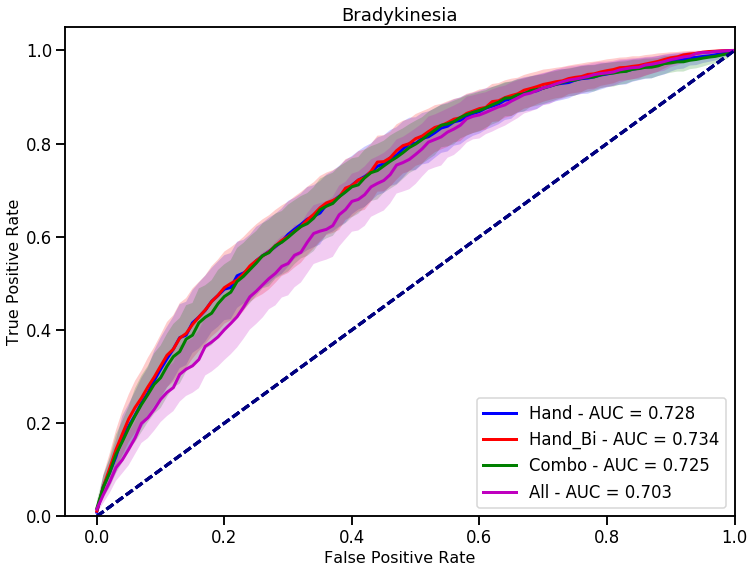

In [11]:
SensorAnalysis('Bradykinesia', BradyData)

Hand 0.790026774981 (0.7419944112099589, 0.83805913875107108)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Hand_Bi 0.787383857607 (0.73801375215326648, 0.83675396305985339)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Combo 0.786731923661 (0.71829793517877061, 0.85516591214275173)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


All 0.764901390704 (0.69149927053079241, 0.8383035108776643)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


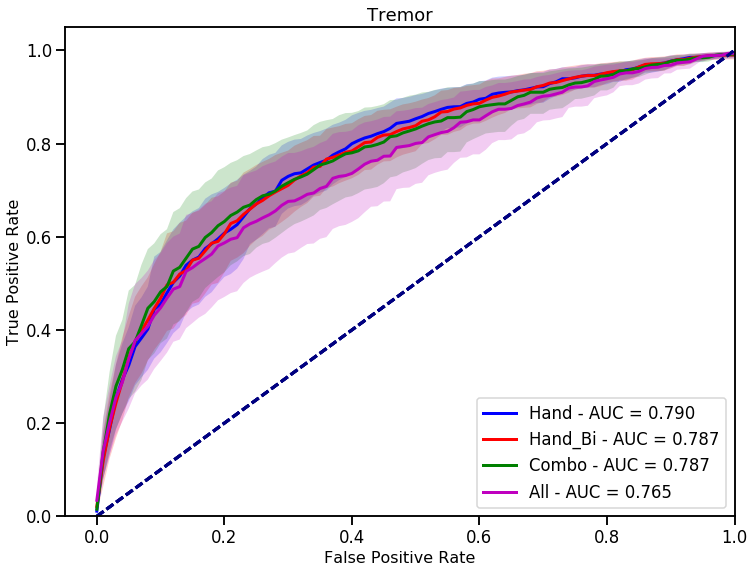

In [63]:
SensorAnalysis('Tremor', TremorData)

## Effect of number of training subjects

In [60]:
def SubjectAnalysis(symptom):
    AX = None
    with open('Hand_' + symptom + '_Data.pkl', 'rb') as file:
        Data = pickle.load(file)

    Data = Data[Data.Subject!=1020]
    Data = Data[~Data[symptom].isnull()]
    Data
    Dataorig = Data.copy()
    reps = 50
    AUROC_PlotValue = pd.DataFrame()
    Comp = None
    for n in range(len(Data.Subject.unique())-3,0,-1):
        try: 
            with open(symptom + '_' + str(n) + '.pkl','rb') as file:
                group_res = pickle.load(file)
        except:
            Data = Dataorig.copy()
            X = Data.iloc[:,7:].as_matrix()
            fnames = Data.iloc[:,7:].columns.values

            indp = ((Data[symptom]>0))
            indp = indp.values
            y = indp.astype(int) #target 

            res, group_res = LNSOCV(Data,X,y,groups=Data.Subject,N=n,reps=reps)
            save_object(group_res,symptom + '_' + str(n) + '.pkl')

        res_group = group_res

        AUC = res_group['Random Forest']['auroc']
    #     if AUROC_PlotValue==None:
    #         AUROC_PlotValue = np.array(AUC)
    #     else:
    #         AUROC_PlotValue = np.vstack((AUROC_PlotValue,AUC))

        T = 'Random Forest'
        NanInds = []
        for i in range(len(res_group[T]['auroc'])):
            if np.isnan(res_group[T]['auroc'][i]):
                NanInds.append(i)
        for i in sorted(NanInds,reverse=True):
            del res_group[T]['tpr'][i]
            del res_group[T]['auroc'][i]

        CI = stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC))

        print(str(len(Data.Subject.unique())-n),np.mean(AUC),CI)

        if not Comp:
            Comp = AUC
        print(stats.ttest_rel(AUC,Comp))
        
        PlotVals = pd.DataFrame(np.array(AUC),columns=['AUC'])
        PlotVals['Training Subjects'] = len(np.unique(Data.Subject))-n
        AUROC_PlotValue = pd.concat((AUROC_PlotValue,PlotVals))
        
    AX = sns.lineplot(data = AUROC_PlotValue,x = 'Training Subjects', y = 'AUC',estimator=np.mean)
    AX.set_title(symptom)

### Plots and results (ttests are against 3 training subjects)

3 0.683134512679 (0.66491532894333127, 0.70135369641535583)
Ttest_relResult(statistic=nan, pvalue=nan)
4 0.69217701495 (0.67570031204465308, 0.70865371785584907)
Ttest_relResult(statistic=0.71647009881188883, pvalue=0.47710220905423961)
5 0.704450908631 (0.68999879450245549, 0.71890302275988405)
Ttest_relResult(statistic=1.9243014777830509, pvalue=0.060134325982758412)
6 0.716475055554 (0.70426182268337512, 0.72868828842472178)
Ttest_relResult(statistic=2.9134027069428718, pvalue=0.0053725459908434848)
7 0.713987878729 (0.70039425544771894, 0.7275815020107872)
Ttest_relResult(statistic=3.3021957986326926, pvalue=0.0017957986473771956)
8 0.733313142475 (0.71795950581651924, 0.74866677913275603)
Ttest_relResult(statistic=3.8576650023951751, pvalue=0.00033454666713896003)
9 0.732816273843 (0.71738988879583077, 0.74824265888941244)
Ttest_relResult(statistic=4.0401901529692275, pvalue=0.00018781840301474207)
10 0.739941793279 (0.7244303707383779, 0.75545321582024272)
Ttest_relResult(statist

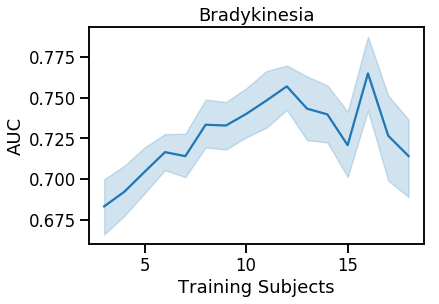

In [61]:
SubjectAnalysis('Bradykinesia')  

3 0.761482844513 (0.74421192563979355, 0.77875376338631475)
Ttest_relResult(statistic=nan, pvalue=nan)
4 0.780591714388 (0.76772180208425689, 0.79346162669256781)
Ttest_relResult(statistic=1.6177107506383059, pvalue=0.11214515548987213)
5 0.789405474211 (0.7749465670042972, 0.80386438141763961)
Ttest_relResult(statistic=2.3864932426769725, pvalue=0.020916103886813801)
6 0.788919947678 (0.77667135035476076, 0.80116854500109891)
Ttest_relResult(statistic=2.9610585820948652, pvalue=0.0047159874419762868)
7 0.793545305109 (0.78112777663392174, 0.80596283358406673)
Ttest_relResult(statistic=2.941002938800612, pvalue=0.0049826094672740648)
8 0.792530313032 (0.77980277319802993, 0.80525785286669738)
Ttest_relResult(statistic=3.143829307882279, pvalue=0.0028308057774847095)
9 0.798979627436 (0.78629648879610026, 0.81166276607599708)
Ttest_relResult(statistic=3.3616538540347798, pvalue=0.0015093004582856658)
10 0.805801408478 (0.79561857084381327, 0.81598424611186071)
Ttest_relResult(statistic=

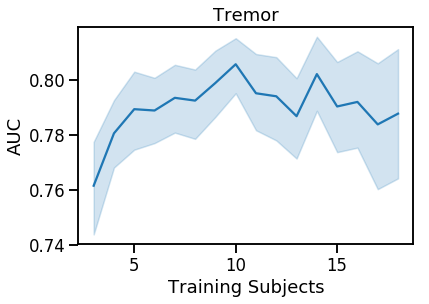

In [62]:
SubjectAnalysis('Tremor')

## Symptom detection across activities

In [71]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose-Left','Motor #4: Finger to Nose-Right','Motor #5: Alternating Hand Movements-Left','Motor #5: Alternating Hand Movements-Right']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB+taskB1,taskC,taskD]
tasks = tasks# + [list(np.concatenate(tasks))]

In [75]:
with open('Hand_' + 'Bradykinesia' + '_Data.pkl', 'rb') as file:
    Data = pickle.load(file)

In [82]:
symptom = 'Bradykinesia'
Data = Data[Data.Subject!=1020]
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index
Data[symptom].unique()

array([ 1.,  0.,  2.,  3.])

In [108]:
Data[(Data.Subject==1004)&(Data.Task=='Motor #4: Finger to Nose-Right')].Tremor.unique()

array([ 1.,  0.])

In [ ]:
with open('Hand_' + symptom + '_Data.pkl', 'rb') as file:
    Data = pickle.load(file)

#remove nan rows for current symptom
Data = Data[Data.Subject!=1020]
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Tasks(Data,X,y,groups,tasks)
save_object(res_group,symptom+'_TaskDataResults.pkl')

In [45]:
def TaskAnalysis(symptom):
    # Global Models
    t1=time.time()
    res_all = pd.DataFrame()
    
    # Look for results file or regenerate data
    try:
        with open(symptom + '_TaskDataResults.pkl', 'rb') as f:
            res_group = pickle.load(f)
    except:

        with open('Hand_' + symptom + '_Data.pkl', 'rb') as file:
            Data = pickle.load(file)

        #remove nan rows for current symptom
        Data = Data[Data.Subject!=1020]
        Data=Data[~Data[symptom].isnull()]
        Data=Data.reset_index(drop=True) #reset index

        X = Data.iloc[:,7:].as_matrix()
        # X = StandardScaler().fit_transform(X)
        fnames = Data.iloc[:,7:].columns.values

        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))
        
        groups = Data.Subject.as_matrix()

        res,res_group = LOSOCV_Tasks(Data,X,y,groups,tasks)
        save_object(res_group,symptom+'_TaskDataResults.pkl')
        
    ## Plot Figure
    Tasks = list(res_group.keys())
    AX=None
    #     plt.figure(figsize=(9,6))

    figure = plt.figure()
    figure.set_dpi(100)
    figure.set_size_inches(6.4,4.8)

    cols = ['b','r','g','m','k']
    TaskNames = ['Clinical', 'Walking', 'Gross Motor', 'Fine Motor', 'All']
    for x,T in zip(range(len(Tasks)),Tasks):
        NanInds = []
        for i in range(len(res_group[T]['auroc'])):
            if np.isnan(res_group[T]['auroc'][i]):
                NanInds.append(i)
        for i in sorted(NanInds,reverse=True):
            del res_group[T]['tpr'][i]
            del res_group[T]['auroc'][i]

        AUC = res_group[T]['auroc']
        print(TaskNames[x],np.mean(AUC),
              stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))

        if AX==None:
            AX = plot_roc(res_group[T]['tpr'],res_group[T]['fpr'][0],np.mean(res_group[T]['auroc']),plotname=TaskNames[x],col = cols[x])
        else:
            plot_roc(res_group[T]['tpr'],res_group[T]['fpr'][0],np.mean(res_group[T]['auroc']),plotname=TaskNames[x],ax=AX,col=cols[x])

    plt.savefig(symptom+'Tasks.tiff',format='tiff',dpi=1000)
    plt.savefig(symptom+'Tasks.png',format='png',dpi=1000)

    print('Elapsed time = %.3f min'%((time.time()-t1)/60))  

Clinical 0.730119466369 (0.65665625521945403, 0.80358267751834001)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Walking 0.771093735862 (0.67119015984287889, 0.87099731188208684)
Gross Motor 0.622211089451 (0.54381665044112393, 0.70060552846151314)
Fine Motor 0.757739681841 (0.70247876134071807, 0.81300060234140326)
Elapsed time = 0.111 min


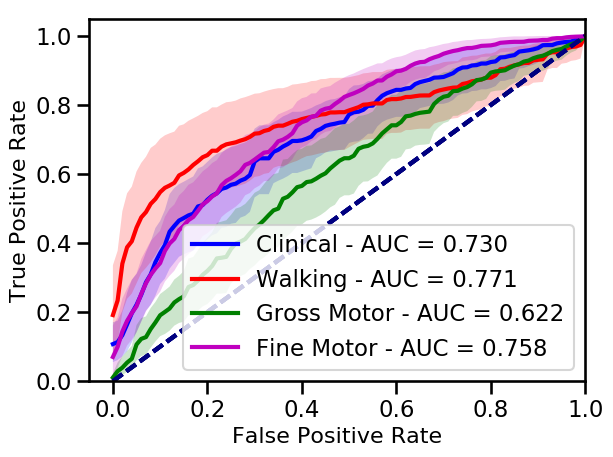

In [46]:
TaskAnalysis('Bradykinesia')

Clinical 0.789236618259 (0.71011905916309792, 0.86835417735422848)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Walking 0.702765089482 (0.53028528869593061, 0.87524489026893693)
Gross Motor 0.560220130343 (0.49360261773831332, 0.62683764294761279)
Fine Motor 0.718656790455 (0.62268966855195829, 0.81462391235778631)
Elapsed time = 0.115 min


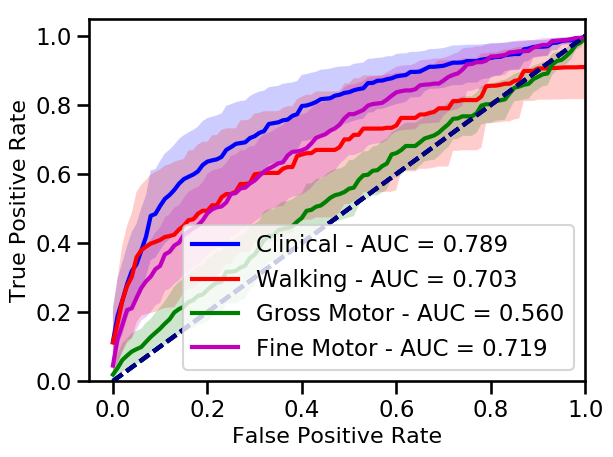

In [47]:
TaskAnalysis('Tremor')

## Task analysis t-tests

In [133]:
with open('Bradykinesia_TaskDataResults.pkl','rb') as file:
    BradykinesiaRes = pickle.load(file)
    
with open('Tremor_TaskDataResults.pkl','rb') as file:
    TremorRes = pickle.load(file)

In [146]:
Control = ('Motor #4: Finger to Nose-Left','Motor #4: Finger to Nose-Right',
           'Motor #5: Alternating Hand Movements-Left','Motor #5: Alternating Hand Movements-Right')
for k in BradykinesiaRes.keys():
    print(k)
    try:
        ControlData = BradykinesiaRes[Control]['auroc']
        CompData = BradykinesiaRes[k]['auroc']
        print(stats.ttest_ind(np.array(ControlData)[~np.isnan(ControlData)],
                              np.array(CompData)[~np.isnan(CompData)]))
    except:
        continue

('Motor #4: Finger to Nose-Left', 'Motor #4: Finger to Nose-Right', 'Motor #5: Alternating Hand Movements-Left', 'Motor #5: Alternating Hand Movements-Right')
Ttest_indResult(statistic=0.0, pvalue=1.0)
('Motor #2: Walking', 'Motor #3: Walking while Counting', 'Motor #1: Standing', 'Motor #13: Sitting')
Ttest_indResult(statistic=-0.68451915776401429, pvalue=0.49857551778211051)
('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
Ttest_indResult(statistic=2.1408176837963508, pvalue=0.040533979623274992)
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Ttest_indResult(statistic=-0.64739460978751961, pvalue=0.5218551210290947)


In [147]:
for k in TremorRes.keys():
    print(k)
    try:
        ControlData = TremorRes[Control]['auroc']
        CompData = TremorRes[k]['auroc']
        print(stats.ttest_ind(np.array(ControlData)[~np.isnan(ControlData)],
                              np.array(CompData)[~np.isnan(CompData)]))
    except:
        continue

('Motor #4: Finger to Nose-Left', 'Motor #4: Finger to Nose-Right', 'Motor #5: Alternating Hand Movements-Left', 'Motor #5: Alternating Hand Movements-Right')
Ttest_indResult(statistic=0.0, pvalue=1.0)
('Motor #2: Walking', 'Motor #3: Walking while Counting', 'Motor #1: Standing', 'Motor #13: Sitting')
Ttest_indResult(statistic=1.1682390128130626, pvalue=0.2541847351824616)
('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
Ttest_indResult(statistic=4.3797048025907666, pvalue=0.00015071283251716502)
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Ttest_indResult(statistic=1.2141459844796483, pvalue=0.23483352644721622)


In [ ]:
save_object(res_group,symptom+'DataResults')
plt.savefig(symptom+'Tasks.svg')
plt.savefig(symptom+'Tasks.png')

## No. of Sessions Analysis

In [41]:
def OneSessionAnalysis(symptom):
    t1=time.time()
    res_all = pd.DataFrame()
    auroc1_1 = []
    auroc2_1 = []

    with open('Hand_' + symptom + '_Data.pkl', 'rb') as file:
        Data = pickle.load(file)

    #remove nan rows for current symptom
    Data = Data[Data.Subject!=1020]
    #remove nan rows for current symptom
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index

    for s in Data.Subject.unique():
        auroc1_v = []; auroc2_v=[]

        #train on 1 session day 1 - CV on all 5 sessions
        dtrain1 = Data[(Data.Subject != s) & (Data.Visit != '4 Weeks')].copy()
        dtest = Data[(Data.Subject == s) & (Data.Visit != '4 Weeks')].copy()
        dtest2 = Data[(Data.Subject == s) & (Data.Visit == '4 Weeks')].copy()

        for v in dtrain1.Visit.unique():
            dtrain=dtrain1[dtrain1.Visit == v]

            X = dtrain.iloc[:,7:].as_matrix()
            fnames = dtrain.iloc[:,7:].columns.values
            indp = ((dtrain[symptom]>0))
            indp = indp.values
            y = indp.astype(int) #target 
            if len(np.unique(y))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in data - skipping')
                continue


#             print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

            clf = RandomForestClassifier(n_estimators=50,random_state=2)
            clf.fit(X,y)
            #test on day 1 for left out subjects
            Xte = dtest.iloc[:,7:].as_matrix()
            yte = (dtest[symptom]>0).values.astype(int) 
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            auroc1_v.append(auroc) #auc for training on current visit 

            #test on day 2
            if dtest2.empty is False:
                Xte = dtest2.iloc[:,7:].as_matrix()
                yte = (dtest2[symptom]>0).values.astype(int) 
                yscore = clf.predict_proba(Xte)
                yscore = yscore[:,1]
                if len(np.unique(yte))>1:
                    auroc = roc_auc_score(yte,yscore)
                else:
                    print('only 1 class in test data - cannot compute roc curve')
                    auroc = np.nan
                auroc2_v.append(auroc) #auc from each subject when tested on day 2
            else:
                auroc2_v.append(np.nan)
            print(auroc1_v[-1],auroc2_v[-1])

        auroc1_1.append(np.nanmean(auroc1_v))
        auroc2_1.append(np.nanmean(auroc2_v))

        print('Subject %d, AUC day1 = %.2f, AUC day2 = %.2f'%(s,auroc1_1[-1],auroc2_1[-1]))
    
    save_object(auroc1_1,symptom + '_1Sess_Day1.pkl')
    save_object(auroc2_1,symptom + '_1Sess_Day2.pkl')
    print('Elapsed time = %.3f min'%((time.time()-t1)/60))
    
def AllSessionAnalysis(symptom):

    t1=time.time()
    res_all = pd.DataFrame()
    auroc1_6 = []
    auroc2_6 = []

    with open('Hand_' + symptom + '_Data.pkl', 'rb') as file:
        Data = pickle.load(file)

    #remove nan rows for current symptom
    Data = Data[Data.Subject!=1020]
    #remove nan rows for current symptom
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index

    for s in Data.Subject.unique():

        #train on 6 sessions (all day 1)
        dtrain = Data[(Data.Subject != s) & (Data.Visit != '4 Weeks') ].copy()
        dtest = Data[(Data.Subject == s) & (Data.Visit != '4 Weeks')].copy()
        dtest2 = Data[(Data.Subject == s) & (Data.Visit == '4 Weeks')].copy()

        X = dtrain.iloc[:,7:].as_matrix()
        fnames = dtrain.iloc[:,7:].columns.values
        indp = ((dtrain[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

        clf = RandomForestClassifier(n_estimators=50,random_state=2)
        clf.fit(X,y)
        #test on day 1 for left out subjects
        Xte = dtest.iloc[:,7:].as_matrix()
        yte = (dtest[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc1_6.append(auroc) #auc from each subject when tested on day 2

        #test on day 2
        if dtest2.empty is False:
            Xte = dtest2.iloc[:,7:].as_matrix()
            yte = (dtest2[symptom]>0).values.astype(int) 
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            auroc2_6.append(auroc) #auc from each subject when tested on day 2
        else:
            auroc2_6.append(np.nan)
        print('Subject %d, AUC day1 = %.2f, AUC day2 = %.2f'%(s,auroc1_6[-1],auroc2_6[-1]))
        
    save_object(auroc1_6,symptom + '_6Sess_Day1.pkl')
    save_object(auroc2_6,symptom + '_6Sess_Day2.pkl')
    print('Elapsed time = %.3f min'%((time.time()-t1)/60))
    
def plotSessionAnalysis(symptom):
    with open(symptom + '_6Sess_Day1.pkl','rb') as f:
        auroc1_6 = pickle.load(f)
    with open(symptom + '_6Sess_Day2.pkl','rb') as f:
        auroc2_6 = pickle.load(f)
    with open(symptom + '_1Sess_Day1.pkl','rb') as f:
        auroc1_1 = pickle.load(f)
    with open(symptom + '_1Sess_Day2.pkl','rb') as f:
        auroc2_1 = pickle.load(f)
    
    Day1NanInds = np.isnan(auroc1_1)|np.isnan(auroc1_6)
    Day2NanInds = np.isnan(auroc2_1)|np.isnan(auroc2_6)
    auroc1_1 = np.asarray(auroc1_1)[~Day1NanInds]
    auroc1_6 = np.asarray(auroc1_6)[~Day1NanInds]
    auroc2_1 = np.asarray(auroc2_1)[~Day2NanInds]
    auroc2_6 = np.asarray(auroc2_6)[~Day2NanInds]
    
    g1 = np.shape(auroc1_1)[0]*['Day 1']
    g2 = np.shape(auroc2_1)[0]*['Day 2']
    df = pd.DataFrame.from_dict({'Test Session':(g1 + g2),'1 Session':(list(auroc1_1) + list(auroc2_1)),
                                 '6 Sessions':(list(auroc1_6) + list(auroc2_6))})
    df_new = pd.melt(df,id_vars=['Test Session'],value_vars=['1 Session','6 Sessions'],var_name=['# Training Sessions'])

    plt.figure(figsize=(8,6))
    ax = sns.boxplot(x='Test Session',y='value',data=df_new,hue='# Training Sessions');
    plt.ylabel('AUROC');
    plt.title(symptom)

    #stats
    # _, pvalue1 = wilcoxon(day1_1.values,day1_5.values,zero_method='wilcox')
    _, pvalue1 = stats.ttest_rel(auroc1_1,auroc1_6)
    print('One Session Day 1 CI: ', np.mean(auroc1_1), 
          stats.t.interval(.95,len(auroc1_1)-1, loc=np.mean(auroc1_1), scale=stats.sem(auroc1_1)))
    print('All Session Day 1 CI: ', np.mean(auroc1_6), 
          stats.t.interval(.95,len(auroc1_6)-1, loc=np.mean(auroc1_6), scale=stats.sem(auroc1_6)))
    print('Bradykinesia Day 1 p-value: %f'%pvalue1)

    # _, pvalue2 = wilcoxon(auroc2_1,auroc2_5,zero_method='wilcox')
    _, pvalue2 = stats.ttest_rel(auroc2_1,auroc2_6)
    print('One Session Day 2 CI: ', np.mean(auroc2_1), 
          stats.t.interval(.95,len(auroc2_1)-1, loc=np.mean(auroc2_1), scale=stats.sem(auroc2_1)))
    print('All Session Day 2 CI: ', np.mean(auroc2_6), 
          stats.t.interval(.95,len(auroc2_6)-1, loc=np.mean(auroc2_6), scale=stats.sem(auroc2_6)))
    print('Bradykinesia Day 2 p-value: %f'%pvalue2)

    x1,x2 = -0.2,0.2
    y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

    if pvalue1 > 0.05:
        plt.text((x1+x2)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);
    else:
        plt.text((x1+x2)*.5, y+h+0.01, "p < %.4f"%pvalue1, ha='center', va='bottom', color=col,fontsize=16);

    x3,x4 = 0.8,1.2
    y, h, col = df_new['value'].max() + 0.04, 0.04, 'k'
    plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)

    if pvalue2 > 0.05:
        plt.text((x3+x4)*.5, y+h, "ns", ha='center', va='bottom', color=col,fontsize=16);
    else:
        plt.text((x3+x4)*.5, y+h, "p < %.4f"%pvalue2, ha='center', va='bottom', color=col,fontsize=16);

In [151]:
symptom = 'Bradykinesia'
OneSessionAnalysis(symptom); AllSessionAnalysis(symptom)

0.712770689593 0.731901900916
0.679223714262 0.666994976854
0.653098805438 0.736383334975
0.699423644908 0.67861715749
0.72753948989 0.697577070817
0.694060672733 0.704274598641
Subject 1004, AUC day1 = 0.69, AUC day2 = 0.70
0.81392694643 nan
0.81942295694 nan
0.755890394282 nan
0.791920078319 nan
0.771617556799 nan
0.679544797431 nan
Subject 1016, AUC day1 = 0.77, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.776881025194 0.646289637136
0.764056234811 0.688525661981
0.808376388645 0.709905197777
0.770899018596 0.704478587774
0.793901117234 0.646812683884
0.771779538379 0.692873488068
Subject 1018, AUC day1 = 0.78, AUC day2 = 0.68
0.80499894537 0.846456125171
0.79278915884 0.878866536881
0.840264896918 0.901651164468
0.84014964871 0.880633066551
0.821307654003 0.867834739347
0.857260745808 0.895450284808
Subject 1019, AUC day1 = 0.83, AUC day2 = 0.88
0.750649841002 0.733122429611
0.718605564536 0.740366972477
0.721166981626 0.715406516925
0.716753754848 0.718063903828
0.714876330988 0.666055045872
0.690754422714 0.709237583043
Subject 1024, AUC day1 = 0.72, AUC day2 = 0.71
0.62320326632 0.726570628251
0.58578025897 0.7868747499
0.574128322991 0.746618647459
0.584382083896 0.84093637455
0.598099082957 0.825890356142
0.585093335699 0.734173669468
Subject 1029, AUC day1 = 0.59, AUC day2 = 0.78
0.70425880377 0.741775362319
0.73255365046 0.68884057971
0.754711330277 0.743224637681
0.75665854745

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.44220565163 0.685595426471
0.456349835931 0.6446072176
0.484410295929 0.63610841713
0.430233524474 0.618702465418
0.49244753695 0.619059772344
0.50159032358 0.634551579807
Subject 1049, AUC day1 = 0.47, AUC day2 = 0.64
0.700384957199 0.509563846558
0.690846215125 0.513137151865
0.695494711443 0.521597477667
0.677082613841 0.501208617972
0.713503893317 0.555806621125
0.66124457215 0.478770362585
Subject 1051, AUC day1 = 0.69, AUC day2 = 0.51
0.726922517034 nan
0.740324836942 nan
0.730298172548 nan
0.757910555337 nan
0.753840773445 nan
0.754826042343 nan
Subject 1052, AUC day1 = 0.74, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.710574502174 nan
0.702384699016 nan
0.726900463493 nan
0.735404983978 nan
0.708523475051 nan
0.660402122911 nan
Subject 1053, AUC day1 = 0.71, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.767329567734 nan
0.774674127343 nan
0.741120232283 nan
0.776240796503 nan
0.778301723336 nan
0.753510414976 nan
Subject 1054, AUC day1 = 0.77, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.685507887365 nan
0.68780095034 nan
0.641347713174 nan
0.677501445922 nan
0.678920151056 nan
0.677813311559 nan
Subject 1055, AUC day1 = 0.67, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.761701144955 nan
0.708829034689 nan
0.706667963148 nan
0.732894960741 nan
0.654291756813 nan
0.698225441816 nan
Subject 1056, AUC day1 = 0.71, AUC day2 = nan
Elapsed time = 2.796 min


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Rows w Bradykinesia 13759/26651 = 0.52
Subject 1004, AUC day1 = 0.72, AUC day2 = 0.69
Rows w Bradykinesia 12775/26449 = 0.48
Subject 1016, AUC day1 = 0.74, AUC day2 = nan
Rows w Bradykinesia 13385/26585 = 0.50
Subject 1018, AUC day1 = 0.80, AUC day2 = 0.72
Rows w Bradykinesia 13783/26527 = 0.52
Subject 1019, AUC day1 = 0.86, AUC day2 = 0.91
Rows w Bradykinesia 13212/26497 = 0.50
Subject 1024, AUC day1 = 0.73, AUC day2 = 0.71
Rows w Bradykinesia 13262/26339 = 0.50
Subject 1029, AUC day1 = 0.61, AUC day2 = 0.85
Rows w Bradykinesia 13518/26607 = 0.51
Subject 1030, AUC day1 = 0.75, AUC day2 = 0.72
Rows w Bradykinesia 12457/25995 = 0.48
Subject 1032, AUC day1 = 0.57, AUC day2 = 0.70
Rows w Bradykinesia 13788/26383 = 0.52
Subject 1038, AUC day1 = 0.70, AUC day2 = 0.38
Rows w Bradykinesia 13439/26475 = 0.51
Subject 1044, AUC day1 = 0.76, AUC day2 = 0.79
Rows w Bradykinesia 13657/26685 = 0.51
Subject 1046, AUC day1 = 0.79, AUC day2 = 0.77
Rows w Bradykinesia 14076/26779 = 0.53
Subject 1047, AU

One Session Day 1 CI:  0.744821568594 (0.7039571719654103, 0.78568596522269174)
All Session Day 1 CI:  0.77152277689 (0.72795292187402516, 0.8150926319066919)
Bradykinesia Day 1 p-value: 0.000066
One Session Day 2 CI:  0.82422195843 (0.75081162547163594, 0.89763229138757406)
All Session Day 2 CI:  0.855838554679 (0.79147202217544166, 0.92020508718197269)
Bradykinesia Day 2 p-value: 0.000303


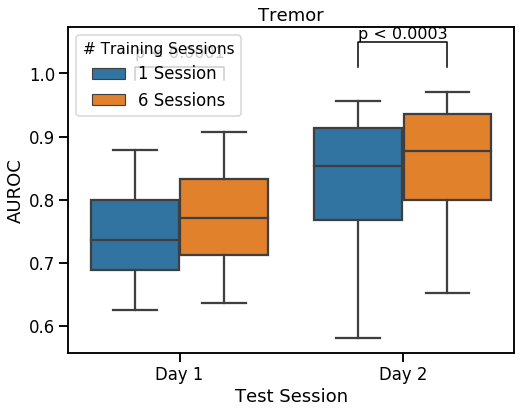

In [42]:
plotSessionAnalysis(symptom)

In [24]:
symptom = 'Tremor'
OneSessionAnalysis(symptom); AllSessionAnalysis(symptom)

0.775391137712 0.779060509554
0.803883157453 0.775378184713
0.827218525227 0.733777866242
0.822175080065 0.77627388535
0.806080025726 0.764530254777
0.762761195989 0.708698248408
Subject 1004, AUC day1 = 0.80, AUC day2 = 0.76
0.817342369852 nan
0.824372087915 nan
0.723160054499 nan
0.68297765772 nan
0.753745884853 nan
0.618275278628 nan
Subject 1016, AUC day1 = 0.74, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.805402645063 0.949103375527
0.801336380003 0.82805907173
0.830269353275 0.943565400844
0.82224414901 0.925501054852
0.794017449107 0.971255274262
0.804917947653 0.944883966245
Subject 1018, AUC day1 = 0.81, AUC day2 = 0.93
0.685476062399 0.798714548051
0.67868746638 0.851764945929
0.651425497579 0.810344827586
0.660835574682 0.870842685166
0.668427469966 0.92226076311
0.649714900484 0.963476841461
Subject 1019, AUC day1 = 0.67, AUC day2 = 0.87
0.682033342804 0.605167464115
0.696993719052 0.70009569378
0.728488513678 0.716459330144
0.707642285291 0.677033492823
0.655956373285 0.57980861244
0.663452415983 0.651578947368
Subject 1024, AUC day1 = 0.69, AUC day2 = 0.66
0.726578559744 0.916753132732
0.753034160659 0.851571021896
0.749282966357 0.865857876393
0.732934599294 0.818713917046
0.724608413677 0.774895575598
0.676287584325 0.715659669567
Subject 1029, AUC day1 = 0.73, AUC day2 = 0.82
0.870056011535 0.95063893761
0.845607808341 0.814958656978
0.853435559006 0.870709095465
0.8510952

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.794983958402 0.836348314607
0.778934247889 0.822724719101
0.803710587454 0.796530898876
0.793075930228 0.760969101124
0.78607884353 0.712612359551
0.772219640816 0.703904494382
Subject 1049, AUC day1 = 0.79, AUC day2 = 0.77
only 1 class in test data - cannot compute roc curve
nan 0.908626198083
only 1 class in test data - cannot compute roc curve
nan 0.964856230032
only 1 class in test data - cannot compute roc curve
nan 0.811821086262
only 1 class in test data - cannot compute roc curve
nan 0.908626198083
only 1 class in test data - cannot compute roc curve
nan 0.895846645367
only 1 class in test data - cannot compute roc curve
nan 0.962939297125
Subject 1051, AUC day1 = nan, AUC day2 = 0.91


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.616920207495 nan
0.610179154281 nan
0.678449393833 nan
0.700506717375 nan
0.592988648948 nan
0.552241796351 nan
Subject 1052, AUC day1 = 0.63, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


only 1 class in test data - cannot compute roc curve
nan nan
only 1 class in test data - cannot compute roc curve
nan nan
only 1 class in test data - cannot compute roc curve
nan nan
only 1 class in test data - cannot compute roc curve
nan nan
only 1 class in test data - cannot compute roc curve
nan nan
only 1 class in test data - cannot compute roc curve
nan nan
Subject 1053, AUC day1 = nan, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.844365828092 nan
0.774344863732 nan
0.820885744235 nan
0.912080712788 nan
0.9125 nan
0.849790356394 nan
Subject 1054, AUC day1 = 0.85, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.640673122163 nan
0.627041997711 nan
0.615233287516 nan
0.629144862415 nan
0.645495226179 nan
0.607812137238 nan
Subject 1055, AUC day1 = 0.63, AUC day2 = nan


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.745949286309 nan
0.694439911788 nan
0.725908573183 nan
0.695870525797 nan
0.691837179808 nan
0.681187950853 nan
Subject 1056, AUC day1 = 0.71, AUC day2 = nan
Elapsed time = 3.262 min


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Rows w Tremor 8135/35232 = 0.23
Subject 1004, AUC day1 = 0.84, AUC day2 = 0.79
Rows w Tremor 7300/35158 = 0.21
Subject 1016, AUC day1 = 0.81, AUC day2 = nan
Rows w Tremor 8137/35308 = 0.23
Subject 1018, AUC day1 = 0.83, AUC day2 = 0.95
Rows w Tremor 8228/35280 = 0.23
Subject 1019, AUC day1 = 0.67, AUC day2 = 0.89
Rows w Tremor 7795/35154 = 0.22
Subject 1024, AUC day1 = 0.71, AUC day2 = 0.70
Rows w Tremor 7509/35028 = 0.21
Subject 1029, AUC day1 = 0.76, AUC day2 = 0.86
Rows w Tremor 8205/35276 = 0.23
Subject 1030, AUC day1 = 0.89, AUC day2 = 0.93
Rows w Tremor 8196/34644 = 0.24
Subject 1032, AUC day1 = 0.78, AUC day2 = 0.95
Rows w Tremor 7199/35012 = 0.21
Subject 1038, AUC day1 = 0.77, AUC day2 = 0.86
Rows w Tremor 8235/35150 = 0.23
Subject 1044, AUC day1 = 0.91, AUC day2 = 0.97
Rows w Tremor 7904/35404 = 0.22
Subject 1046, AUC day1 = 0.72, AUC day2 = 0.65
Rows w Tremor 8293/35532 = 0.23
Subject 1047, AUC day1 = 0.68, AUC day2 = nan
Rows w Tremor 7648/35524 = 0.22
Subject 1049, AUC day1

One Session Day 1 CI:  0.744821568594 (0.7039571719654103, 0.78568596522269174)
All Session Day 1 CI:  0.77152277689 (0.72795292187402516, 0.8150926319066919)
Bradykinesia Day 1 p-value: 0.000066
One Session Day 2 CI:  0.82422195843 (0.75081162547163594, 0.89763229138757406)
All Session Day 2 CI:  0.855838554679 (0.79147202217544166, 0.92020508718197269)
Bradykinesia Day 2 p-value: 0.000303


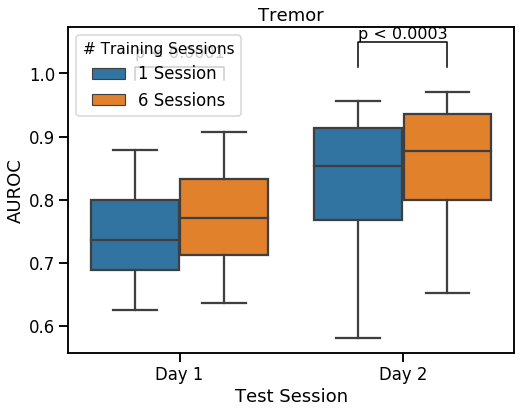

In [43]:
plotSessionAnalysis(symptom)

## CNN Sensor Results
Load results from CNNModels.ipynb and plots

Hand vs. Hand Ttest_relResult(statistic=nan, pvalue=nan)
Hand CI:  0.689661575606 (0.62656148015578206, 0.75276167105671721)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Hand vs. Bi Ttest_relResult(statistic=-0.36995156470190199, pvalue=0.71573551808133273)
Bi CI:  0.681469309371 (0.63109740222812749, 0.73184121651309009)
Hand vs. Combo Ttest_relResult(statistic=-2.6911058914236885, pvalue=0.014930925272131199)
Combo CI:  0.60282319966 (0.54187435203228607, 0.66377204728786465)


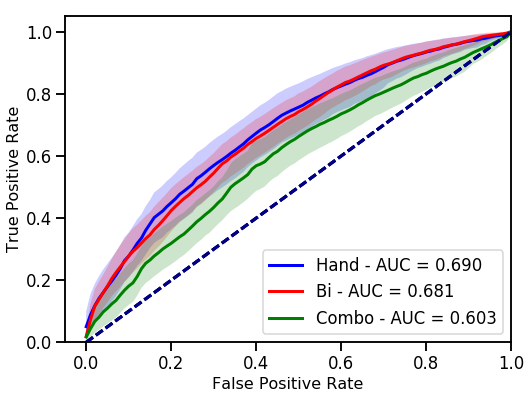

In [39]:
symptom = 'Brady'
AX = None
c = ['b','r','g','m','k']
coldict = {'Hand': c[0], 'Bi': c[1], 'Combo': c[2]}
plt.figure(figsize=(8,6))
with open(os.path.join('CNN_'+symptom+'Hand','AUROC.pkl'),'rb') as file:
    AUC_Comp = pickle.load(file)
for S in coldict.keys():
    dir = 'CNN_' + symptom + S
    with open(os.path.join(dir,'FPR.pkl'),'rb') as file:
        fpr = pickle.load(file)
    with open(os.path.join(dir,'TPR.pkl'),'rb') as file:
        tpr = pickle.load(file)
    with open(os.path.join(dir,'AUROC.pkl'),'rb') as file:
        AUC = pickle.load(file)
    print('Hand vs. '+S,stats.ttest_rel(AUC,AUC_Comp))
    print(S+' CI: ', np.mean(AUC), stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))
    if AX==None:
        AX = plot_roc(tpr,fpr[0],np.mean(AUC),plotname=S,col=coldict[S])
    else:
        plot_roc(tpr,fpr[0],np.mean(AUC),ax=AX,plotname=S,col=coldict[S])

Hand vs. Hand Ttest_relResult(statistic=nan, pvalue=nan)
Hand CI:  0.775672882311 (0.73153508437273973, 0.81981068025001491)


/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Hand vs. Bi Ttest_relResult(statistic=-1.9920947899434951, pvalue=0.062672894475661975)
Bi CI:  0.697309137997 (0.61994279807732966, 0.77467547791603264)
Hand vs. Combo Ttest_relResult(statistic=-3.8223206573072064, pvalue=0.0013631665947632968)
Combo CI:  0.595113227776 (0.50131461736469007, 0.68891183818701252)


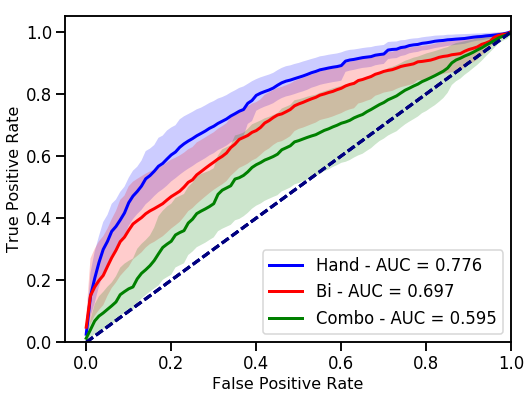

In [40]:
symptom = 'Tremor'
AX = None
c = ['b','r','g','m','k']
coldict = {'Hand': c[0], 'Bi': c[1], 'Combo': c[2]}
plt.figure(figsize=(8,6))
with open(os.path.join('CNN_'+symptom+'Hand','AUROC.pkl'),'rb') as file:
    AUC_Comp = pickle.load(file)
for S in coldict.keys():
    dir = 'CNN_' + symptom + S
    with open(os.path.join(dir,'FPR.pkl'),'rb') as file:
        fpr = pickle.load(file)
    with open(os.path.join(dir,'TPR.pkl'),'rb') as file:
        tpr = pickle.load(file)
    with open(os.path.join(dir,'AUROC.pkl'),'rb') as file:
        AUC = pickle.load(file)
    print('Hand vs. '+S,stats.ttest_rel(AUC,AUC_Comp))
    print(S+' CI: ', np.mean(AUC), stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))
    if AX==None:
        AX = plot_roc(tpr,fpr[0],np.mean(AUC),plotname=S,col=coldict[S])
    else:
        plot_roc(tpr,fpr[0],np.mean(AUC),ax=AX,plotname=S,col=coldict[S])